<a href="https://colab.research.google.com/github/mattrusso22-account/Artificial-Neural-Network/blob/master/Special_Topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
!pip install -U ray

     |████████████████████████████████| 23.1MB 5.5MB/s 
     |████████████████████████████████| 204kB 45.7MB/s 
     |████████████████████████████████| 2.9MB 35.9MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 133kB 53.1MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 1.3MB 40.4MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 143kB 48.6MB/s 
     |████████████████████████████████| 296kB 44.2MB/s 
     |████████████████████████████████| 102kB 1.4MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp36-none-any.whl size=12622 sha256=7f056999c74ddb790d6810c047eb06f960e62c7d4aa40228a69888f6dacb67c5
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size

In [ ]:
import tensorflow as tf
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

import os
import numpy as np
import torch
import torch.optim as optim
from torchvision import datasets
from ray.tune.examples.mnist_pytorch import train, test, ConvNet, get_data_loaders

import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.utils import validate_save_restore


%matplotlib inline
import matplotlib.style as style
import matplotlib.pyplot as plt
style.use("ggplot")

# Transforming the data to torch tensors and normalize it 
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.1307), ((0.3081)))])

# Preparing training set and testing set
trainset = torchvision.datasets.MNIST('mnist', train=True, 
download=True, transform=transform)
testset = torchvision.datasets.MNIST('mnist', train=False,download=True, transform=transform)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


In [ ]:
# Choosing suitable values for the epochs, batch size and learning rate
epochs = 100
batch_size= 10
learning_rate = 0.01

In [ ]:
# Preparing training loader and testing loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
shuffle=False, num_workers=0)

In [ ]:
# Computing the shape of the training set and testing set
trainset_shape = trainloader.dataset.train_data.shape
testset_shape = testloader.dataset.test_data.shape

# Printing the computed shapes
print(trainset_shape, testset_shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [ ]:
# Computing the size of the minibatch for training set and testing set
trainset_batchsize = trainloader.batch_size
testset_batchsize = testloader.batch_size

# Printing sizes of the minibatch
print(trainset_batchsize, testset_batchsize)

10 10


In [28]:
class Net(nn.Module):
    def __init__(self):    
        # Parameters of the net
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 150)
        self.fc2 = nn.Linear(150, 60)
        self.fc3 = nn.Linear(60, 55)
        self.fc4 = nn.Linear(55, 35)
        self.fc5 = nn.Linear(35, 20)
        self.fc6 = nn.Linear(20, 10)

    def forward(self, x):    
        # Forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [29]:
model = Net()   
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

for batch_idx, data_target in enumerate(trainloader):
    data = data_target[0]
    target = data_target[1]
    data = data.view(-1, 28 * 28)
    optimizer.zero_grad()

    # Completing a forward pass
    output = model(data)

    # Computing the loss, gradients and changing the weights
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

In [30]:
class PytorchTrainble(tune.Trainable):
    def _setup(self, config):
        self.device = torch.device("cpu")
        self.trainloader, self.testloader = get_data_loaders()
        self.model = ConvNet().to(self.device)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.get("lr", 0.01),
            momentum=config.get("momentum", 0.9))

    def _train(self):
      train(self.model, self.optimizer, self.trainloader, device=self.device)
      acc = test(self.model, self.testloader, self.device)
      return {"mean_accuracy": acc}

    def _save(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path

    def _restore(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))
        
    def reset_config(self, new_config):
        del self.optimizer
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=new_config.get("lr", 0.01),
            momentum=new_config.get("momentum", 0.9))
        return True


ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)

validate_save_restore(PytorchTrainble)
validate_save_restore(PytorchTrainble, use_object_store=True)
print("Success!")

2020-11-21 18:56:48,460	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


Success!


In [31]:
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="mean_accuracy",
    mode="max",
    perturbation_interval=5,
    hyperparam_mutations={
        # distribution for resampling
        "lr": lambda: np.random.uniform(0.0001, 1),
        # allow perturbations within this set of categorical values
        "momentum": [0.8, 0.9, 0.99],
    }
)

In [32]:
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)

analysis = tune.run(
    PytorchTrainble,
    name="pbt_test",
    scheduler=scheduler,
    reuse_actors=True,
    verbose=1,
    stop={
        "training_iteration": 100,
    },
    num_samples=4,
    
    # PBT starts by training many neural networks in parallel with random hyperparameters. 
    config={
        "lr": tune.uniform(0.001, 1),
        "momentum": tune.uniform(0.001, 1),
    })

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
PytorchTrainble_5e78c_00000,TERMINATED,,0.0901262,0.8,0.809375,100,44.5386
PytorchTrainble_5e78c_00001,TERMINATED,,0.108151,0.9,0.753125,100,44.446
PytorchTrainble_5e78c_00002,TERMINATED,,0.140822,0.8,0.821875,100,44.2753
PytorchTrainble_5e78c_00003,TERMINATED,,0.246992,0.8,0.796875,100,43.8417


2020-11-21 18:59:00,837	INFO tune.py:439 -- Total run time: 106.34 seconds (106.31 seconds for the tuning loop).


In [23]:
! cat ~/ray_results/pbt_test/pbt_global.txt

["3_lr=0.68386,momentum=0.88609", "2_lr=0.62855,momentum=0.50404", 9, 10, {"lr": 0.6285490805445286, "momentum": 0.5040423820414944}, {"lr": 0.38174625261493644, "momentum": 0.9}]
["3_lr=0.68386,momentum=0.88609", "2_lr=0.62855,momentum=0.50404", 24, 25, {"lr": 0.6285490805445286, "momentum": 0.5040423820414944}, {"lr": 0.5028392644356229, "momentum": 0.99}]
["2_lr=0.62855,momentum=0.50404", "1_lr=0.41933,momentum=0.3651", 34, 35, {"lr": 0.4193306270304462, "momentum": 0.36510208806360145}, {"lr": 0.335464501624357, "momentum": 0.99}]
["0_lr=0.84737,momentum=0.97057", "1_lr=0.41933,momentum=0.3651", 39, 39, {"lr": 0.4193306270304462, "momentum": 0.36510208806360145}, {"lr": 0.335464501624357, "momentum": 0.99}]
["0_lr=0.84737,momentum=0.97057", "1_lr=0.41933,momentum=0.3651", 39, 40, {"lr": 0.4193306270304462, "momentum": 0.36510208806360145}, {"lr": 0.5031967524365354, "momentum": 0.9}]
["0_lr=0.84737,momentum=0.97057", "2_lr=0.62855,momentum=0.50404", 49, 45, {"lr": 0.335464501624357

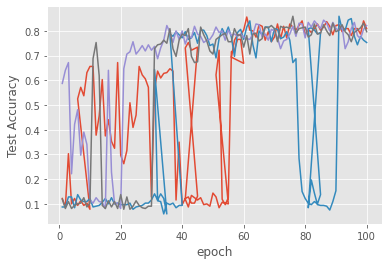

In [33]:
# Plot by wall-clock time

dfs = analysis.fetch_trial_dataframes()
# This plots everything on the same plot
ax = None
for d in dfs.values():
    ax = d.plot("training_iteration", "mean_accuracy", ax=ax, legend=False)

plt.xlabel("epoch"); plt.ylabel("Test Accuracy");